# Experiment Data Analysis

This notebook analyzes the data collected during experiment trials. 

---

### In this notebook:
- Data treatment
- RT analysis
- Summary statistics

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from pathlib import Path
from brokenaxes import brokenaxes


---

## Dataset Creation

Missing responses (coded as RT = -1) will be excluded from analysis.

In [2]:
dtype_spec = {
    'target': 'string',
    'modality': 'category',  # or 'string'
    'RT': 'float64'
}

trial_data_folder = Path("../res/expdata/trials/").resolve()

trial_files = list(trial_data_folder.glob("subject_*.csv"))

print(f"> Found {len(trial_files)} trial data files")

trials_df = [pd.read_csv(trial, dtype=dtype_spec) for trial in trial_files]

print("> Concatenating data...")

experiment_df = pd.concat(trials_df, ignore_index=True)

print("> Cleaning data...")

experiment_df['RT'] = np.where(experiment_df['RT'] == -1, np.nan, experiment_df['RT'])

print("\n" + "-"*40 + "\n"   + "> Experiment data frame info:\n")
experiment_df.info()

print("\n" + "-"*40 + "\n"   + "> Experiment data frame head:")
experiment_df.head()

> Found 27 trial data files
> Concatenating data...
> Cleaning data...

----------------------------------------
> Experiment data frame info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   target    810 non-null    string  
 1   modality  810 non-null    category
 2   RT        708 non-null    float64 
dtypes: category(1), float64(1), string(1)
memory usage: 13.8 KB

----------------------------------------
> Experiment data frame head:


,target,modality,RT
0,68-scenes\library-68\Fairfield_Pub_Library_A.jpg,low,5.803473
1,68-scenes\bridge-68\beach_07_06_flickr.jpg,control,4.804812
2,68-scenes\skyscraper-68\a462057.jpg,low,5.242834
3,68-scenes\house-68\house_06_09_google.jpg,low,4.538618
4,68-scenes\castle-68\FreeFoto_castle_1_22.jpg,control,2.914942


---

## General Analysis

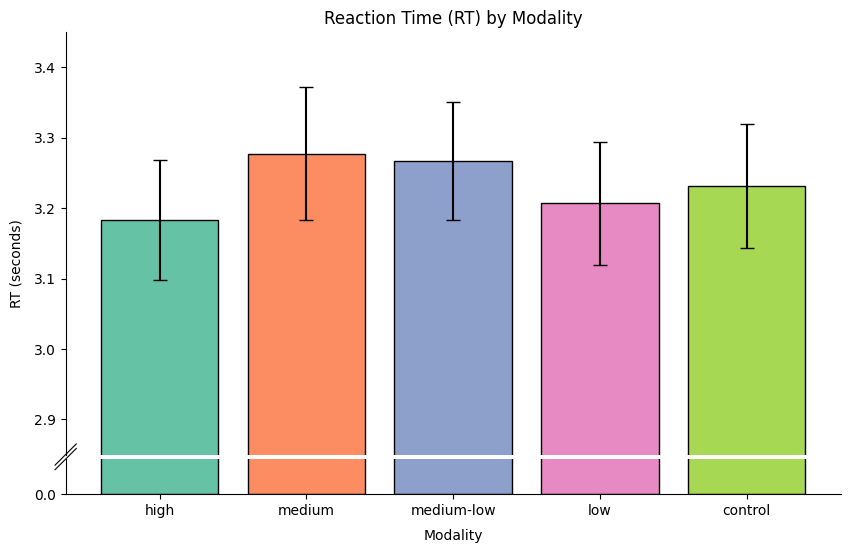

,count,mean,median,std
modality,,,,
high,145,3.183131,3.151553,1.030476
medium,142,3.277531,3.167772,1.123002
medium-low,144,3.266979,3.219503,1.000522
low,140,3.207091,3.161887,1.032640
control,137,3.231786,2.992054,1.034018


In [3]:
# Compute mean, median, std, and count
modality_order = ['high', 'medium', 'medium-low', 'low', 'control']

stats_df = (
    experiment_df.groupby('modality', observed=False)['RT']
    .agg(['count', 'mean', 'median', 'std', 'sem'])
    .reindex(modality_order)
)

# Set up colors
palette = sns.color_palette("Set2", n_colors=len(modality_order))[:5]

# Set up broken axis
fig = plt.figure(figsize=(10, 6))
bax = brokenaxes(ylims=((0, .05), (2.85, 3.45)), hspace=0.02)

# Plot bars manually with error bars
x = np.arange(len(modality_order))
bax.bar(
    x,
    stats_df['mean'],
    yerr=stats_df['sem'],
    capsize=5,
    color=palette,
    tick_label=modality_order,
    edgecolor='black'
)

# Customize labels and title
bax.set_xlabel("Modality", labelpad=25)
bax.set_ylabel("RT (seconds)")
bax.set_title("Reaction Time (RT) by Modality")
plt.show()

stats_df[['count', 'mean', 'median', 'std']]

---

## ANOVA Test

In [4]:

control_df = experiment_df[experiment_df['modality'] == 'control']['RT'].dropna()
low_df = experiment_df[experiment_df['modality'] == 'low']['RT'].dropna()
medium_df = experiment_df[experiment_df['modality'] == 'medium']['RT'].dropna()
mediumlow_df = experiment_df[experiment_df['modality'] == 'medium-low']['RT'].dropna()
high_df = experiment_df[experiment_df['modality'] == 'high']['RT'].dropna()

# Run ANOVA
f_stat, p_value = stats.f_oneway(low_df, mediumlow_df, medium_df, high_df, control_df)

print(f"ANOVA result: F = {f_stat:.4f}, p = {p_value:.4f}")

ANOVA result: F = 0.2067, p = 0.9347


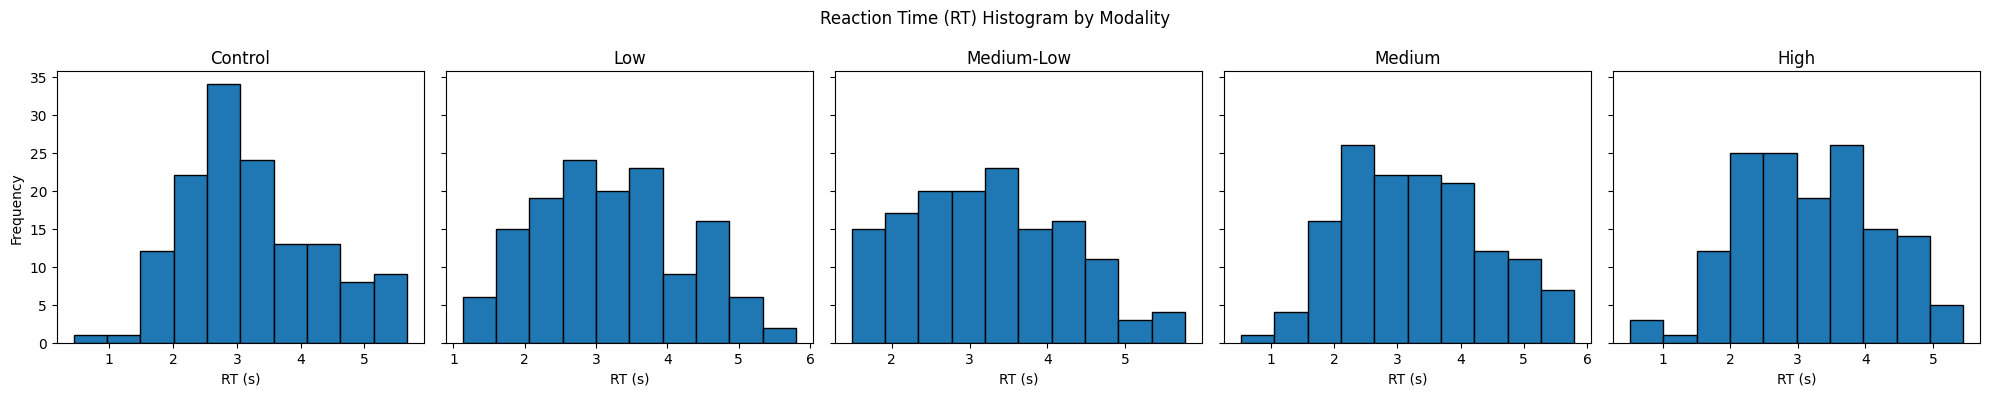

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
bins = 10

# Plot each histogram
axes[0].hist(control_df, bins=bins, edgecolor='black')
axes[0].set_title("Control")
axes[0].set_xlabel("RT (s)")
axes[0].set_ylabel("Frequency")

axes[1].hist(low_df, bins=bins, edgecolor='black')
axes[1].set_title("Low")
axes[1].set_xlabel("RT (s)")

axes[2].hist(mediumlow_df, bins=bins, edgecolor='black')
axes[2].set_title("Medium-Low")
axes[2].set_xlabel("RT (s)")

axes[3].hist(medium_df, bins=bins, edgecolor='black')
axes[3].set_title("Medium")
axes[3].set_xlabel("RT (s)")

axes[4].hist(high_df, bins=bins, edgecolor='black')
axes[4].set_title("High")
axes[4].set_xlabel("RT (s)")

# Final layout tweaks
plt.suptitle("Reaction Time (RT) Histogram by Modality")
plt.tight_layout()
plt.show()

In [10]:
from scipy.stats import ttest_ind

# Define a helper function for t-test and print results
def run_ttest(modality_name, control_df, experiment_df):
    modality_df = experiment_df[experiment_df['modality'] == modality_name]['RT'].dropna()
    t_stat, p_val = ttest_ind(modality_df, control_df, equal_var=False)  # Welch's t-test
    print(f"T-test {modality_name} vs control: t = {t_stat:.4f}, p = {p_val:.4f}")

# Run the t-tests
print("\n" + "-"*40 + "\n" + "> T-tests vs control:")
for modality in ['low', 'medium-low', 'medium', 'high']:
    run_ttest(modality, control_df, experiment_df)



----------------------------------------
> T-tests vs control:
T-test low vs control: t = -0.1989, p = 0.8425
T-test medium-low vs control: t = 0.2897, p = 0.7723
T-test medium vs control: t = 0.3541, p = 0.7235
T-test high vs control: t = -0.3956, p = 0.6927
